<a href="https://colab.research.google.com/github/ctarrington/data-science-hw/blob/master/kalman-filters/rlabbe/position_and_velocity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install filterpy

In [2]:
import math

import numpy as np

from matplotlib.pyplot import plot
from matplotlib import pyplot as plt

from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise


## Goal
Kalman filter for position and velocity as a hidden state variable

In [14]:
# Helpers
def data_and_noise(x0 = 0, v = 2, a = 0, var = 1, count = 30, seed = 123):
  np.random.seed(seed)

  std = math.sqrt(var)
  xs = np.array([x0 + t * v + 0.5 * a * t ** 2 for t in range(count)])
  noise = np.array(np.random.normal(0, std, count))
  return (xs, xs + noise)

def show_filter_value(actuals, measurements, estimates, gains):
  burn_in = 6
  measurement_error = measurements[burn_in:] - actuals[burn_in:]
  estimate_error = estimates[burn_in:] - actuals[burn_in:]
  estimate_advantage = np.abs(measurement_error) - np.abs(estimate_error)
  mean_advantage = np.mean(estimate_advantage)

  # everything together
  _, subplots = plt.subplots(1,3, figsize=(15, 7), constrained_layout=True)
  subplots[0].plot(actuals, '-b', label='Actuals')
  subplots[0].plot(measurements, 'yo', label='Measurements')
  subplots[0].plot(estimates, '--gx', label='Estimates')
  subplots[0].legend()

  # advantage
  burnt_times = range(burn_in, len(estimates))
  subplots[1].plot(burnt_times, estimate_advantage, 'go')
  subplots[1].set_xlim(left=0)
  subplots[1].hlines(0, burn_in, len(estimates))
  subplots[1].set_title('Mean estimate advantage %.1f' % mean_advantage)

  # kalman gains (position)
  subplots[2].plot(gains)
  subplots[2].set_title('Kalman gain (position)')
  
  plt.show()

x_state
 [[100.]
 [-20.]]
P_state_covariance
 [[500.   0.]
 [  0.  49.]]
F_state_transition_function (aka A)
 [[1. 1.]
 [0. 1.]]
H_measurement_conversion 
 [[1. 0.]]
R_measurement_covariance 
 [[1.]]


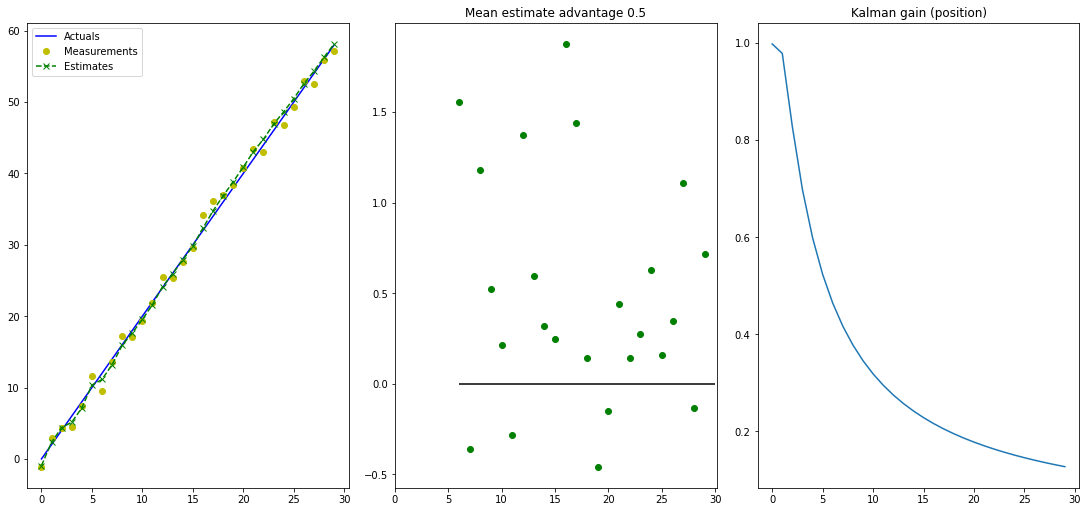

In [15]:
dt = 1.
I2 = np.identity(2, dtype=int)

x_state = np.array([[100., -20.]]).T   # initial state position and velocity
P_state_covariance = np.array([[500., 0], [0, 49.]])  # weak priors
F_state_transition_function = np.array([[1., dt], [0., 1.]])  # kinematics: x = x0 + v * dt, v = v 
H_measurement_conversion = np.array([[1.,0]])  # convert state to measurement space
R_measurement_covariance = np.array([[1.]])

print('x_state\n', x_state)
print('P_state_covariance\n', P_state_covariance)
print('F_state_transition_function (aka A)\n', F_state_transition_function)
print('H_measurement_conversion \n', H_measurement_conversion)
print('R_measurement_covariance \n', R_measurement_covariance)
actuals, measurements = data_and_noise()

xs = []
kg_ps = []
for measured_position in measurements:
  # Predict state and state covariance
  x_state = F_state_transition_function.dot(x_state)
  P_state_covariance = F_state_transition_function.dot(P_state_covariance)
  P_state_covariance = P_state_covariance.dot(F_state_transition_function.T)

  # calculate the kalman gain
  top = P_state_covariance.dot(H_measurement_conversion.T)
  bottom = H_measurement_conversion.dot(P_state_covariance)
  bottom = bottom.dot(H_measurement_conversion.T)
  bottom = np.add(bottom, R_measurement_covariance)
  with np.errstate(divide='ignore', invalid='ignore'):
    kalman_gain = np.divide(top, bottom)
    kalman_gain[np.isnan(kalman_gain)] = 0
  
  z_measurement = np.array([[measured_position]])
  y_residual = np.subtract(z_measurement, H_measurement_conversion.dot(x_state))
  x_state = np.add(x_state, kalman_gain.dot(y_residual))

  # update process covariance = (I - K * H) covariance
  P_state_covariance = np.subtract(I2, kalman_gain.dot(H_measurement_conversion)).dot(P_state_covariance)

  xs.append(x_state[0][0])
  kg_ps.append(kalman_gain[0][0])

show_filter_value(actuals, measurements, xs, kg_ps)


kf
 KalmanFilter object
dim_x = 2
dim_z = 1
dim_u = 0
x = [[100 -20]].T
P = [[500   0]
     [  0  49]]
x_prior = [[0. 0.]].T
P_prior = [[1. 0.]
           [0. 1.]]
x_post = [[0. 0.]].T
P_post = [[1. 0.]
          [0. 1.]]
F = [[1 1]
     [0 1]]
Q = [[0. 0.]
     [0. 0.]]
R = [[1]]
H = [[1 0]]
K = [[0. 0.]].T
y = [[0.]]
S = [[0.]]
SI = [[0.]]
M = [[0.]]
B = None
z = [[None]]
log-likelihood = -708.3964185322641
likelihood = 2.2250738585072014e-308
mahalanobis = 0.0
alpha = 1.0
inv = <function inv at 0x7fc9840e40d0>


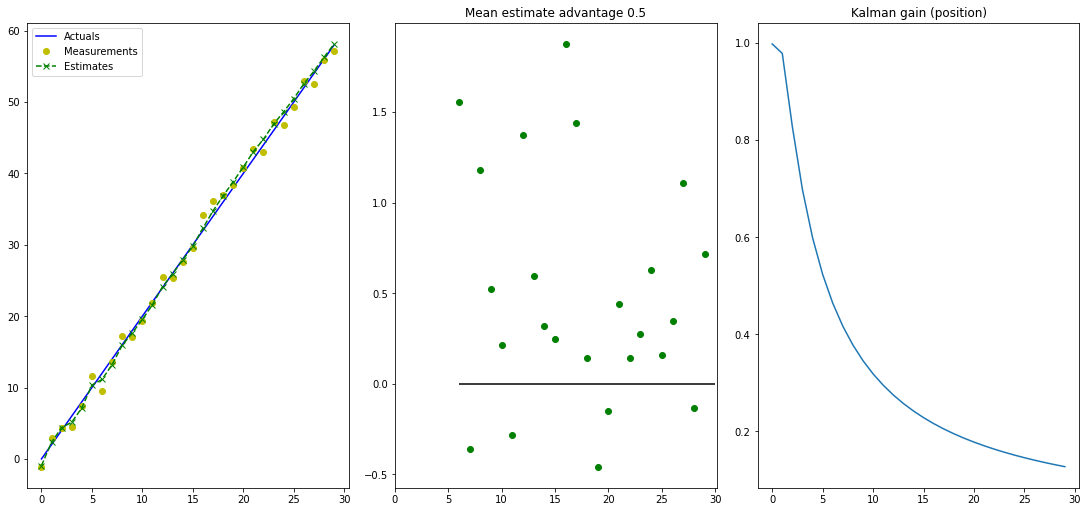

In [16]:
dt = 1

x_state = np.array([[100, -20]]).T   # initial state position and velocity
P_state_covariance = np.array([[500, 0], [0, 49]])  # weak priors
F_state_transition_function = np.array([[1, dt], [0, 1]])  # kinematics: x = x0 + v * dt, v = v 
H_measurement_conversion = np.array([[1,0]])  # convert state to measurement space
R_measurement_covariance = np.array([[1]])

actuals, measurements = data_and_noise()


kf = KalmanFilter(dim_x=2, dim_z=1)
kf.x = x_state
kf.F = F_state_transition_function
kf.H = H_measurement_conversion
kf.R = R_measurement_covariance
kf.P = P_state_covariance
kf.Q *= 0
print('kf\n', kf)

xs = []
kg_ps = []
for measured_position in measurements:
  z = np.array([[measured_position]])
  kf.predict()
  kf.update(z)
  xs.append(kf.x[0][0])
  kg_ps.append(kf.K[0][0])

show_filter_value(actuals, measurements, xs, kg_ps)